In [72]:
import torch

import numpy as np
import os
import yaml
import matplotlib.pyplot as plt

from src.datasets import MultiObjectDataset, MultiObjectDataLoader
from src.model import MonetClassifier, SlotAttentionClassifier, Monet, SlotAttention
from src.utils import import_from_path

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [124]:
def visualize_images(images):
    images = images.detach().cpu()
    if images.shape[1] == 3:
        N_images = 25
        fig=plt.figure(figsize=(12, 12))
        for i in range(1,N_images+1):
            fig.add_subplot(int(np.sqrt(N_images))  , int(np.sqrt(N_images)), i)
            plt.imshow(np.transpose(images[i-1], (1,2,0)))
        fig.tight_layout()
        plt.show()
    else:
        num_slot = images.shape[1]
        N_images = 10
        fig=plt.figure(figsize=(2*num_slot, 2*N_images))
        for i in range(0,N_images):
            for j in range(1,num_slot +1):
                fig.add_subplot(N_images , num_slot, num_slot*i + j)
                plt.imshow(images[i][j-1], cmap='gray', vmin=0, vmax=1.)
        fig.tight_layout()
        plt.show()

In [177]:
def visualize_masks(images, masks):
    colors = [[255, 0, 0],
              [0, 255, 0],
              [0, 0, 255],
              [255, 255, 0],
              [255, 0, 255],
              [0, 255, 255]]
    def create_uniform_image(color_idx, size = 64):
        color_idx = color_idx % len(colors)
        image = []
        for k in range(size):
            r = []
            for l in range(size):
                r.append(colors[color_idx])
            image.append(r)
        return np.array(image)
        
    images = images.detach().cpu().numpy()
    masks = torch.nn.Upsample(scale_factor=4)(masks)
    masks = masks.detach().cpu().numpy()
    num_slot = images.shape[1]
    N_images = 5
    fig=plt.figure(figsize=(2*2, 2*N_images))
    for i in range(0,N_images):
        fig.add_subplot(N_images+1 , 2, 2*i +1)
        plt.imshow(np.transpose(images[i], (1,2,0)))
        
        masked_image = np.transpose(images[i], (1,2,0)).copy()
        #masked_image = np.zeros((64,64,3))
        for j in range(0,num_slot):
            masked_image += np.expand_dims(masks[i][j], axis = 2)*create_uniform_image(j)
        fig.add_subplot(N_images+1 , 2, 2*i+2)
        plt.imshow(masked_image)
    fig.tight_layout()
    plt.show()

# Supervised

In [60]:
config = 'config/supervised.yml'
dataset = 'multi_sprite'
#dataset = 'clevr'
prediction = 'all_carac'

with open(config) as config_file:
    config = yaml.safe_load(config_file)['datasets'][dataset]
    
# Get Objects and Functions
ObjectDataset = import_from_path(config['objectdataset']['filepath'], config['objectdataset']['class'])
        
transform = import_from_path(config['transform']['filepath'], config['transform']['fct'])
    
if config['dataloader']['class'] == 'default':
    DataLoader = torch.utils.data.DataLoader
else:
    DataLoader = import_from_path(config['dataloader']['filepath'], config['dataloader']['class'])
    
#Create DataLoader
trainset = ObjectDataset(config['prediction'][prediction]['filepath'], train=True, transform= transform)
    
valset = ObjectDataset(config['prediction'][prediction]['filepath'], train=False, transform= transform)
    
trainloader = DataLoader(trainset, batch_size=config['params']['batch_size'], shuffle=True, num_workers=0)
    
valoader = DataLoader(trainset, batch_size=config['params']['batch_size'], shuffle=False, num_workers=0)

## Monet

In [61]:
model_net = MonetClassifier(config['params'], 
                            config['params']['height'],
                            config['params']['width'],
                            config['prediction'][prediction]['dim_points'])

## Slot Attention

In [62]:
model_net = SlotAttentionClassifier(config['params'], 
                            config['params']['height'],
                            config['params']['width'],
                            config['prediction'][prediction]['dim_points']).cuda()
if dataset == 'multi_sprite':
    slot_att_state_dict = './checkpoints/saved/slot_multi_sprites_supervised_all_carac.ckpt'
elif dataset == 'clevr':
    slot_att_state_dict = './checkpoints/saved/slot_clevr_supervised_all_carac.ckpt'

model_net.load_state_dict(torch.load(slot_att_state_dict))

<All keys matched successfully>

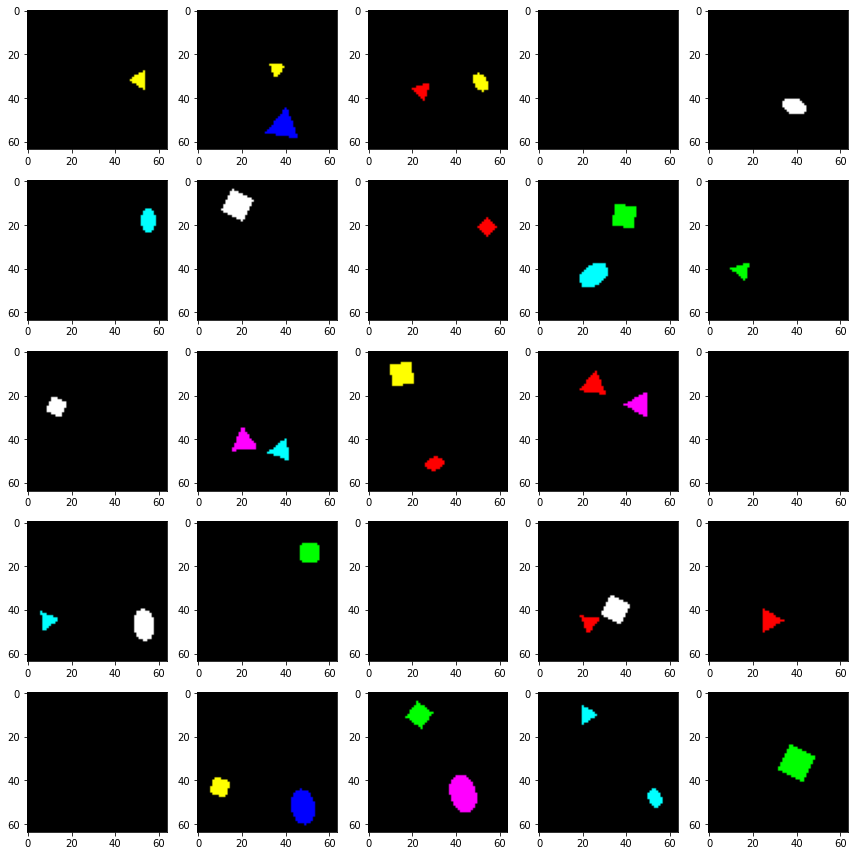

In [178]:
samples, labels = iter(trainloader).next()
visualize_images(samples)

In [179]:
dict_output = model_net(samples.cuda())
outputs_slot = dict_output['outputs_slot']
masks = dict_output['masks'].reshape(-1,4,16,16).transpose(2,3)

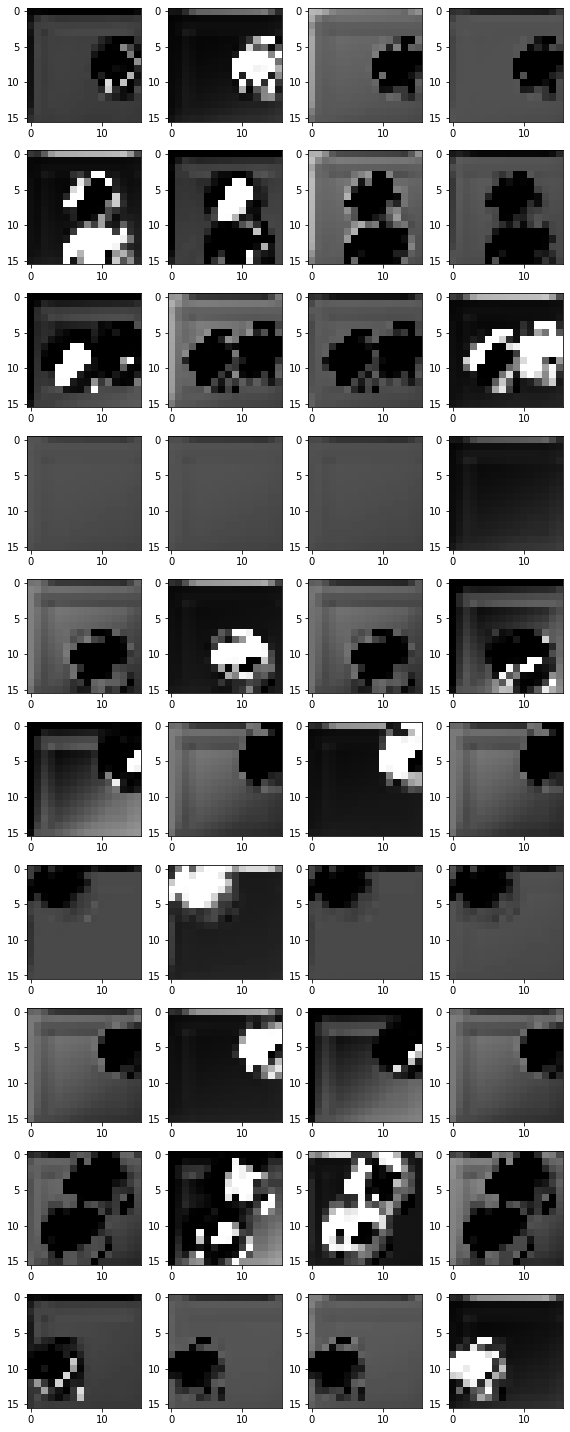

In [180]:
#visualize_images(torch.nn.Upsample(scale_factor=4)(masks.reshape(-1,4,16,16)))
visualize_images(masks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


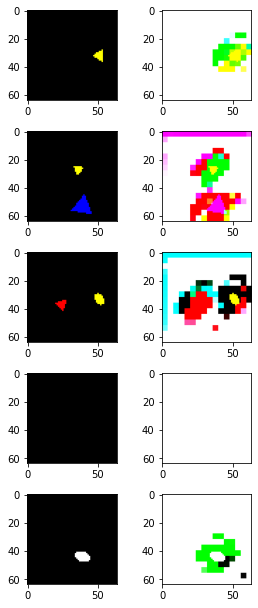

In [181]:
visualize_masks(samples, masks)

In [154]:
im.shape

(64, 64, 3)

# Unsupervised

In [22]:
config = 'config/unsupervised.yml'
dataset = 'multi_sprite'

with open(config) as config_file:
    config = yaml.safe_load(config_file)['datasets'][dataset]
    
# Get Objects and Functions
ObjectDataset = import_from_path(config['objectdataset']['filepath'], config['objectdataset']['class'])
        
transform = import_from_path(config['transform']['filepath'], config['transform']['fct'])
    
if config['dataloader']['class'] == 'default':
    DataLoader = torch.utils.data.DataLoader
else:
    DataLoader = import_from_path(config['dataloader']['filepath'], config['dataloader']['class'])

#Create DataLoader
trainset = ObjectDataset(config['data']['filepath'], train=True, transform= transform)
    
trainloader = DataLoader(trainset, batch_size=config['params']['batch_size'], shuffle=True, num_workers=0)

## Monet

In [23]:
model_net = Monet(config['params'], 
                  config['params']['height'],
                  config['params']['width'])

model_net.load_state_dict(torch.load(config['params']['checkpoint_file']))

<All keys matched successfully>

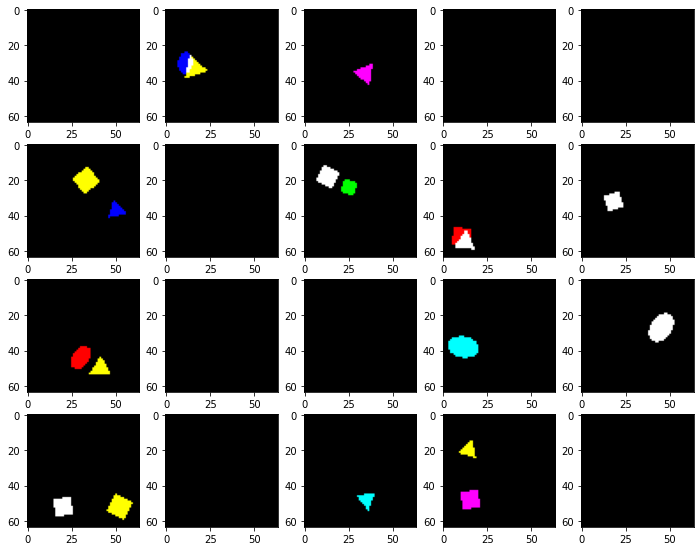

In [24]:
samples, labels = iter(trainloader).next()
visualize_images(samples)

In [25]:
dict_output = model_net(samples)
reconstructions = dict_output['reconstructions']
masks = dict_output['masks']

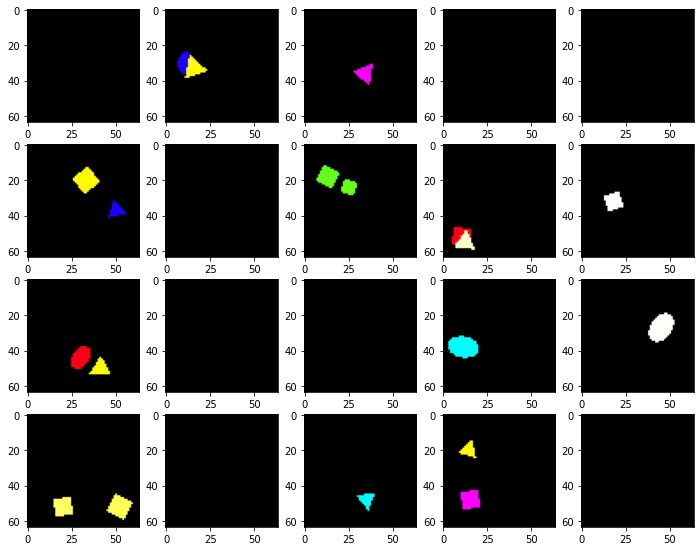

In [26]:
visualize_images(reconstructions)

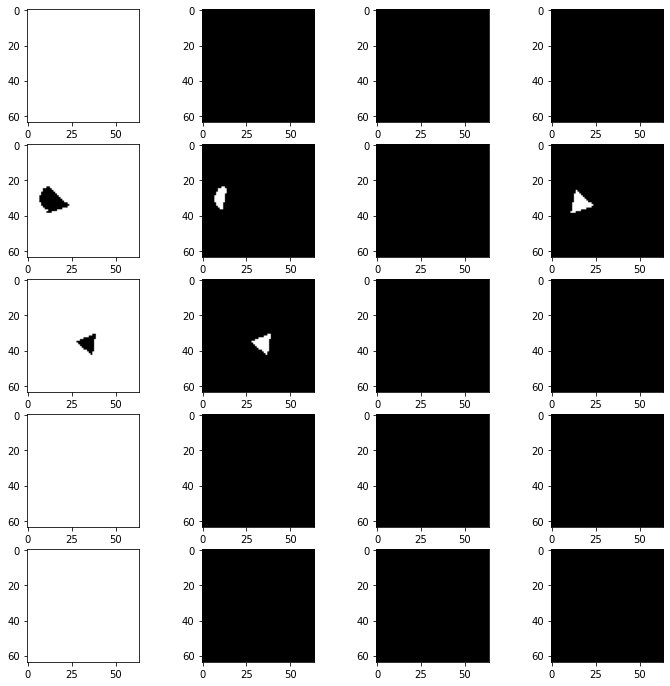

In [27]:
visualize_images(masks)